In [1]:
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 48.3 MB/s eta 0:00:00


In [4]:
import tensorflow_text as text

### **Data Preprocessing**

In [5]:
import pandas as pd

data = pd.read_csv("updated_inkognito_trainingset.csv")

In [6]:
df = data.iloc[:1500,:]

In [7]:
df.drop('Unnamed: 0',axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


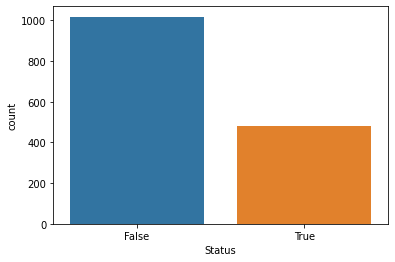

In [8]:
sns.countplot(x=df['Status'])

In [9]:
df['Status'].value_counts()

False    1018
True      482
Name: Status, dtype: int64

In [10]:
df.head()
# False -> 0
# True -> 1

,text,Status
0,@115712 I understand. I would like to assist y...,False
1,@sprintcare and how do you propose we do that,False
2,@sprintcare I have sent several private messag...,False
3,@115712 Please send us a Private Message so th...,False
4,@sprintcare I did.,False


In [11]:
df.dtypes

text      object
Status      bool
dtype: object

In [12]:
df['Status'] = df['Status'].astype(str)

<ipython-input-12-df1dec9dc489>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Status'] = df['Status'].astype(str)


In [13]:
df.dtypes

text      object
Status    object
dtype: object

**Handling class imbalancing using oversampling technique**

In [14]:
X = df[['text']]
y = df['Status']

In [15]:
# Convert the text data and binary response variable to arrays
X_array = X.to_numpy()
y_array = y.to_numpy()


In [16]:
# Randomly oversample the binary response variable
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_array.reshape(-1,1), y_array)


In [17]:
# Convert the resampled data back to a dataframe
df_new = pd.DataFrame({'text': X_resampled.ravel(), 'Status': y_resampled})

In [18]:
df_new.head()

,text,Status
0,@115712 I understand. I would like to assist y...,False
1,@sprintcare and how do you propose we do that,False
2,@sprintcare I have sent several private messag...,False
3,@115712 Please send us a Private Message so th...,False
4,@sprintcare I did.,False


In [19]:
df_new['Status'].value_counts()

False    1018
True     1018
Name: Status, dtype: int64

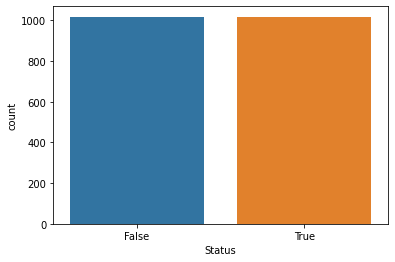

In [20]:
sns.countplot(x=df_new['Status'])

**Binary Encoding**

In [21]:
df_new = pd.get_dummies(df_new, columns=['Status']) #to convert the categorical variable to numerical

In [22]:
df_new.columns

Index(['text', 'Status_False', 'Status_True'], dtype='object')

In [23]:
df_new.drop('Status_False',axis=1,inplace=True)

In [24]:
df_new = df_new.rename(columns={'Status_True': 'Status'})

In [25]:
df_new['Status'].value_counts()

0    1018
1    1018
Name: Status, dtype: int64

In [26]:
df_new.head()

,text,Status
0,@115712 I understand. I would like to assist y...,0
1,@sprintcare and how do you propose we do that,0
2,@sprintcare I have sent several private messag...,0
3,@115712 Please send us a Private Message so th...,0
4,@sprintcare I did.,0


In [27]:
df_new.shape

(2036, 2)

### **Build the BERT Model**

In [28]:
#split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_new['text'],df_new['Status'], test_size = 1/4, stratify =df_new['Status'])
# stratify -> ensure that the class distribution of the data is the same in both sets

In [29]:
X_train.shape , y_train.shape

((1527,), (1527,))

In [30]:
X_test.shape , y_test.shape

((509,), (509,))

In [31]:
Counter(y_train) # class distribution of y_train

Counter({0: 764, 1: 763})

In [32]:
Counter(y_test) #class distribution of y_test

Counter({0: 254, 1: 255})

Here we use Functional model to build the BERT layers

In [33]:
# L-12 bert model urls
#preprocess url
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#encoder url
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

#### **BERT with FFNN**

In [34]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer
preprocessed_text = bert_preprocess(text_input) #preprocess layer
outputs = bert_encoder(preprocessed_text) #bert encoder layer
# output shape = (number of records, 768)
# each sentence size = (768,1)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output']) #dropout layer
## output['pooled_output'] is the input of this layer and output of previous layer
## output['pooled_output'] gives the bert embdded values
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l) #dense layer / last layer

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [35]:
outputs['pooled_output'] #get the shape of bert embedding values

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_1')>

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [37]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics='accuracy')

In [38]:
#train the model
model_history = model.fit(X_train, y_train,validation_split=0.3, epochs=100)

Epoch 1/100
34/34 [==============================] - 30s 513ms/step - loss: 0.6818 - accuracy: 0.5581 - val_loss: 0.6423 - val_accuracy: 0.7015
Epoch 2/100
34/34 [==============================] - 16s 483ms/step - loss: 0.6395 - accuracy: 0.6386 - val_loss: 0.6165 - val_accuracy: 0.6688
Epoch 3/100
34/34 [==============================] - 16s 488ms/step - loss: 0.6143 - accuracy: 0.6732 - val_loss: 0.6142 - val_accuracy: 0.6688
Epoch 4/100
34/34 [==============================] - 22s 650ms/step - loss: 0.6177 - accuracy: 0.6554 - val_loss: 0.5876 - val_accuracy: 0.6558
Epoch 5/100
34/34 [==============================] - 17s 490ms/step - loss: 0.5846 - accuracy: 0.6929 - val_loss: 0.5688 - val_accuracy: 0.7451
Epoch 6/100
34/34 [==============================] - 16s 485ms/step - loss: 0.5770 - accuracy: 0.7032 - val_loss: 0.5534 - val_accuracy: 0.7102
Epoch 7/100
34/34 [==============================] - 16s 488ms/step - loss: 0.5577 - accuracy: 0.7154 - val_loss: 0.5380 - val_accuracy:

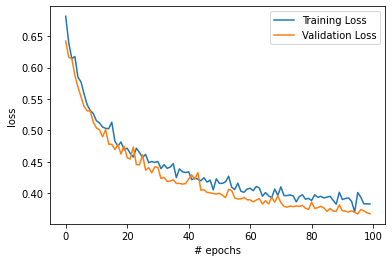

In [39]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

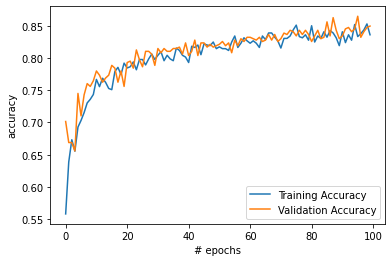

In [40]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('# epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [41]:
y_predicted = model.predict(X_test) #predict the unseen data. this is 2 dimensional array
y_predicted = y_predicted.flatten() #one dimensional array

16/16 [==============================] - 6s 342ms/step


In [42]:
import numpy as np

# if predicted values > 0.5, set it as 1. o/w set as 0
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted.shape

(509,)

In [43]:
#get the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)

Text(33.0, 0.5, 'Truth')

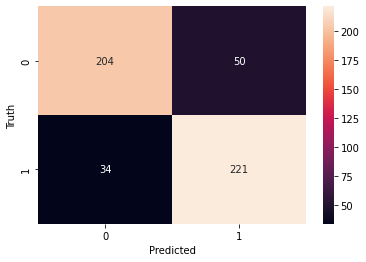

In [44]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       254
           1       0.82      0.87      0.84       255

    accuracy                           0.83       509
   macro avg       0.84      0.83      0.83       509
weighted avg       0.84      0.83      0.83       509

